In [1]:
%load_ext jupyter_cms

In [2]:
# <help>
print("I am also included in the help")

I am also included in the help


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re

In [4]:
def make_contig_df(contig_path, contig_name):
    """
    Make contig Dataframe from fasta file.
    """    
    f_handle = open(contig_path+'/'+contig_name, mode='r')
    contigs = SeqIO.parse(f_handle, 'fasta')
    contig_length = []
    contig_id =[]
    contig_GC = []
    assembly_id = []
    for x in contigs:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
        contig_GC.append(SeqUtils.GC(x.seq))
        assembly_id.append(p_and_a_ctg_file_name)
    s1 = pd.Series(contig_id, name='ID')
    s2 = pd.Series(contig_length, name='Length')
    s3 = pd.Series(contig_GC, name='%GC')
    s4 = pd.Series(assembly_id, name="Assembly")
    contig_df = pd.concat([s1, s2, s3, s4], axis=1)
    f_handle.close()
    return contig_df

In [5]:
#function to add another column for P and A_contig identification to dataframe
def P_and_A_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df['ID']:
        if "_" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [6]:
#function that compares a seed with a result dataframe. It assesses if any initial IDs are missing from the result df
#and adds them with '0' in all columns to the result df
#ADD VALUE ERROR CHECK FOR EMPTY SEED_DF
def no_hit_df_extension(seed_df, result_df):
    """function that compares a seed with a result dataframe. 
    It assesses if any initial IDs are missing from the result df
    and adds them with '0' in all columns except the ID column.
    The first column in each dataframe needs to be labled 'ID'."""
    if len(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0]))) == 0:
        #test if there actually missing values
        return pd.DataFrame()
    else:
        no_hit_sr = pd.Series(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0])))
        #make empty dataframe for no_hits
        empty = np.array([[0]*(len(result_df.columns)-1) for x in range(len(no_hit_sr))])
        no_hit_df = pd.DataFrame(empty, columns =result_df.columns[1:])
        no_hit_df[result_df.columns.tolist()[0]] = no_hit_sr
        no_hit_df = no_hit_df[result_df.columns]
        return no_hit_df

In [7]:
def coverage_df_generator(file_path, file_name, seq_type):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_df
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [8]:
def coverage_df_generator_all(file_path, file_name, seq_type, seed_df):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    This also adds the IDs for which no hits have been reported.
    It returns a sorted df on the first ID column.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #get no hit df, append and sort
    coverage_all_df = coverage_df.append(no_hit_df_extension(seed_df, coverage_df))
    coverage_all_df = coverage_all_df.sort_values(by=[coverage_all_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_all_df
    #no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [9]:
def add_cov_to_summary(sum_df, cov_df):
    """add coverage dataframe last "Average Coverage" column to blast summary df"""
    sum_sorted_df = sum_df.sort_values(by=[sum_df.columns.tolist()[0]]).reset_index(drop=True)
    cov_sorted_df = cov_df.sort_values(by=[cov_df.columns.tolist()[0]]).reset_index(drop=True)
    if set(sum_sorted_df.iloc[:,0] == cov_sorted_df.iloc[:,0]):
        sum_sorted_df[cov_sorted_df.columns.tolist()[-1]] = cov_sorted_df.iloc[:, -1]
        return sum_sorted_df
    else: #this should be made to raise an error
        print('Dataframes do not have the same ids')

In [10]:
def tc_blast_df(blast_xml_path, blast_xml_file_name, tc_list):
    """
    Returns a df of xml blast hits of target contigs.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.
                                                    #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            for aln in record.alignments:
                NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                title_list.append(aln.title.split('|')[4])
                query_contig.append(title)
                sbj_start_list = []
                query_score_list =[]
                length_list = []
                for hsp in aln.hsps:
                    sbj_start_list.append(hsp.query_start)
                    query_score_list.append(hsp.expect)
                    length_list.append(hsp.align_length)
                sbj_start.append(sbj_start_list)
                score_list.append(query_score_list)
                length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df = tc_blast_df.append(result_df)
    f.close()
    tc_blast_df = tc_blast_df.reset_index(drop=True)
    return tc_blast_df

In [11]:
def tc_blast_search_df(blast_xml_path, blast_xml_file_name, tc_list, search):
    """
    Returns a df of xml blast hits of target contigs were the query title matches the 'search' pattern.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df_2 = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.                                            #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            #set the search term for your favorite blast hit
            for aln in record.alignments:
                #in case the title contains pattern match entered as search string in function
                if re.search(search, aln.title.split('|')[4]):
                    NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                    title_list.append(aln.title.split('|')[4])
                    query_contig.append(title)
                    sbj_start_list = []
                    query_score_list =[]
                    length_list = []
                    for hsp in aln.hsps:
                            sbj_start_list.append(hsp.query_start)
                            query_score_list.append(hsp.expect)
                            length_list.append(hsp.align_length)
                    sbj_start.append(sbj_start_list)
                    score_list.append(query_score_list)
                    length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df_2 = tc_blast_df_2.append(result_df)
            result_df = pd.DataFrame()
    f.close()
    tc_blast_df_2 = tc_blast_df_2.reset_index(drop=True)
    return tc_blast_df_2

In [12]:
def print_first_5_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print the long blast_xml description until you reach #5
    for index,row in blast_xml_df.iterrows():
        if row['ID'] == previous:
            count += 1
            #print(count)
        if count < 6: 
            print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        if row['ID'] != previous:
            count = 0
        previous = row['ID']

In [13]:
def print_all_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print all blast hits
    for index,row in blast_xml_df.iterrows():
        print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        print("E-value",'\t', blast_xml_df.loc[index, 'E-value'])
        print("Contig Pos Aln",'\t', blast_xml_df.loc[index,'Contig Pos Aln'])


In [14]:
#here pull in intial unpolished query file from Falcon p_and_a_ctg and generate a dataframe
p_and_a_ctg_path ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/'
g_prefix = 'v91_cns_gcoords_cur_ph_ctg'
p_and_a_ctg_file_name = g_prefix+'.fa'
handle_1 = open(p_and_a_ctg_path+p_and_a_ctg_file_name)

In [15]:
#outdir for saving figures
outdir_fig = p_and_a_ctg_path+"QC_fig/"
outdir_sum = p_and_a_ctg_path+"QC_sum/"

In [16]:
#here enter your blast file you want to analyze in tabBS1 format
blast_tabBS1_path = p_and_a_ctg_path+'blast/'
blast_tabBS1_handle = g_prefix+'.blast.local.tabBS1.nt'
blast_tabBS2_path = blast_tabBS1_path
blast_tabBS2_handle = g_prefix+'.blast.local.tabBS2.nt'
blast_xml_path = blast_tabBS1_path
blast_xml_file_name =g_prefix+'.blast.local.nt'

In [17]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
cov_path= p_and_a_ctg_path +"LRM/"
cov_file_name= g_prefix + '_all_pbreads.bam.999999999.cov'
seq_type='PacBio'

In [18]:
#here enter the illumina cov file coresponding to p_and_a_ctg_path
cov_path_2 =p_and_a_ctg_path +"SRM/"
cov_file_name_2=g_prefix + '.folder_5_ete.sam.sorted.bam.999999999.cov'
seq_type_2='Illumina'

In [19]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(p_and_a_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
p_and_a_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_1.close()

In [20]:
p_and_a_ctg_df = P_and_A_identifier(p_and_a_ctg_df)

In [21]:
#pull in blast tabBS1 file, and rename header according to tabBS1 format convention
blast_df = pd.read_csv(blast_tabBS1_path+blast_tabBS1_handle, sep='\t', header=None)
header = ['ID', 'sseqid', 'evalue', 'bitscore', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename = dict(zip(blast_df.columns, header))
blast_df.rename(columns=rename,inplace=True)

In [22]:
#pull in blast tabBS2 file, and rename header according to tabBS2 format convention
blast_df_2 = pd.read_csv(blast_tabBS2_path+blast_tabBS2_handle, sep='\t', header=None)
header_2 = ['ID', 'sseqid', 'evalue', 'bitscore', 'qstart', 'qend', 'length', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename_2 = dict(zip(blast_df_2.columns, header_2))
blast_df_2.rename(columns=rename_2,inplace=True)
#sort the dataframe by "ID", "qstart", "bitscore"
blast_df_2 = blast_df_2.sort_values(by=["ID",'qstart','bitscore'], ascending=False).reset_index(drop=True)
#drop everything that is identical on the start position
blast_df_2 = blast_df_2.drop_duplicates(subset=["ID", "qstart"], keep='first').reset_index(drop=True)

In [23]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Kingdom'] = pd.Series(kingdom_list)

In [24]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df_2['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df_2['Kingdom'] = pd.Series(kingdom_list)

In [25]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Superkingdom'] = pd.Series(kingdom_list)

In [26]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df_2['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df_2['Superkingdom'] = pd.Series(kingdom_list)

In [27]:
blast_df = P_and_A_identifier(blast_df)

In [28]:
no_blast_hit_df = no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [29]:
#append original blast_df with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
blast_all_df = blast_df.append(no_blast_hit_df)
blast_all_sorted_df  = blast_all_df.sort_values(by=['ID'])[list(no_blast_hit_df.columns)].reset_index(drop=True)
len(set(blast_all_df['ID'])) ==  len(p_and_a_ctg_df)

True

In [30]:
blast_df_2 = P_and_A_identifier(blast_df_2)

In [31]:
no_blast_hit_df_2 = no_hit_df_extension(p_and_a_ctg_df, blast_df_2)

In [32]:
#append original blast_df_2 with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df_2
blast_all_df_2 = blast_df_2.append(no_blast_hit_df_2)
blast_all_sorted_df_2  = blast_all_df_2.sort_values(by=['ID'])[list(no_blast_hit_df_2.columns)].reset_index(drop=True)
len(set(blast_all_df_2['ID'])) ==  len(p_and_a_ctg_df)

True

In [33]:
#get all Superkingdoms of the dataframe and all contigs
Kingdoms = list(set(blast_all_sorted_df['Kingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [34]:
#get all Superkingdoms of the dataframe and all contigs
Kingdoms_2 = list(set(blast_all_sorted_df_2['Kingdom']))
contigs_2 = sorted(list(set(blast_all_sorted_df_2['ID'])))

In [35]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Kingdoms[Kingdoms.index(0)]

In [36]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Kingdoms_2[Kingdoms_2.index(0)]

In [37]:
#create a df summarizing all blast hits for each contig at the Kingdom level
list_of_summary_series =[]
overall_count = 0
for king in Kingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Kingdom']:
        for x in Series[1:]: #is the list of ['Kingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-King'))
blast_hit_summary_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df['Total King Blast Hits'] = blast_hit_summary_df[blast_hit_summary_df.columns[0]]*0
for x in range(0, (len(Kingdoms))):
    blast_hit_summary_df['Total King Blast Hits'] = blast_hit_summary_df['Total King Blast Hits'] + blast_hit_summary_df[list(blast_hit_summary_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df['%Fungi'] = np.round(blast_hit_summary_df['Fungi']/blast_hit_summary_df['Total King Blast Hits']*100, 2)
blast_hit_summary_df = blast_hit_summary_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df['Total King Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Kingdom'])

0

In [38]:
#create a df summarizing all blast hits for each contig at the Kingdom level for reduced blast_df_2
list_of_summary_series =[]
overall_count = 0
for king in Kingdoms_2:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df_2.groupby('ID')['Kingdom']:
        for x in Series[1:]: #is the list of ['Kingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-King'))
blast_hit_summary_df_2 = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df_2['Total King Blast Hits'] = blast_hit_summary_df_2[blast_hit_summary_df_2.columns[0]]*0
for x in range(0, (len(Kingdoms_2))):
    blast_hit_summary_df_2['Total King Blast Hits'] = blast_hit_summary_df_2['Total King Blast Hits'] + blast_hit_summary_df_2[list(blast_hit_summary_df_2.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df_2['%Fungi'] = np.round(blast_hit_summary_df_2['Fungi']/blast_hit_summary_df_2['Total King Blast Hits']*100, 2)
blast_hit_summary_df_2 = blast_hit_summary_df_2.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df_2['Total King Blast Hits'])- len(blast_all_sorted_df_2.groupby('ID')['Kingdom'])

0

In [39]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms = list(set(blast_all_sorted_df['Superkingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [40]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms_2 = list(set(blast_all_sorted_df_2['Superkingdom']))
contigs_2 = sorted(list(set(blast_all_sorted_df_2['ID'])))

In [41]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms_2[Superkingdoms_2.index(0)]

In [42]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms[Superkingdoms.index(0)]

In [43]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms_2:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df_2.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-blast'))
blast_hit_summary_SK_df_2 = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_SK_df_2['Total Blast Hits'] = blast_hit_summary_SK_df_2[blast_hit_summary_SK_df_2.columns[0]]*0
for x in range(0, (len(Superkingdoms_2))):
    blast_hit_summary_SK_df_2['Total Blast Hits'] = blast_hit_summary_SK_df_2['Total Blast Hits'] + blast_hit_summary_SK_df_2[list(blast_hit_summary_SK_df_2.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_SK_df_2['%Eukaryota'] = np.round(blast_hit_summary_SK_df_2['Eukaryota']/blast_hit_summary_SK_df_2['Total Blast Hits']*100, 2)
blast_hit_summary_SK_df_2 = blast_hit_summary_SK_df_2.fillna(0)
#quick test if all went correct
len(blast_hit_summary_SK_df_2['Total Blast Hits'])- len(blast_all_sorted_df_2.groupby('ID')['Superkingdom'])

0

In [44]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-blast'))
blast_hit_summary_SK_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_SK_df['Total Blast Hits'] = blast_hit_summary_SK_df[blast_hit_summary_SK_df.columns[0]]*0
for x in range(0, (len(Superkingdoms))):
    blast_hit_summary_SK_df['Total Blast Hits'] = blast_hit_summary_SK_df['Total Blast Hits'] + blast_hit_summary_SK_df[list(blast_hit_summary_SK_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_SK_df['%Eukaryota'] = np.round(blast_hit_summary_SK_df['Eukaryota']/blast_hit_summary_SK_df['Total Blast Hits']*100, 2)
blast_hit_summary_SK_df = blast_hit_summary_SK_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_SK_df['Total Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Superkingdom'])

0

In [45]:
p_and_a_ctg_sorted_df = p_and_a_ctg_df.sort_values(by='ID').reset_index(drop=True)

In [46]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df.sort_values(by='ID-King')], axis =1)
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_blast_df, blast_hit_summary_SK_df.sort_values(by='ID-blast')], axis =1)

In [47]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df_2 = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df_2.sort_values(by='ID-King')], axis =1)
p_and_a_ctg_blast_df_2 = pd.concat([p_and_a_ctg_blast_df_2, blast_hit_summary_SK_df_2.sort_values(by='ID-blast')], axis =1)

In [48]:
#quick test if all went alright
set(p_and_a_ctg_blast_df.loc[:,'ID'] == p_and_a_ctg_blast_df.loc[:,'ID-blast'])
#p_and_a_ctg_blast_df[p_and_a_ctg_blast_df['Total Blast Hits'] == 0].count()

{True}

In [49]:
#delete the 'ID-blast' column
del p_and_a_ctg_blast_df['ID-blast']

In [50]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df_2['ID']:
    if "_" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df_2["P_ID"] = pd.Series(primary_ID)

In [51]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df['ID']:
    if "_" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df["P_ID"] = pd.Series(primary_ID)

In [52]:
#safe the reduced blastdf #2 in cwd
p_and_a_ctg_blast_df_2.to_csv(outdir_sum+blast_tabBS1_handle+'.blast_summary_reduced.csv', sep='\t', encoding='utf-8')

In [53]:
outdir_sum

'/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/QC_sum/'

In [54]:
#safe the dataframe in blast_tabBS1_handle dir
p_and_a_ctg_blast_df.to_csv(outdir_sum+blast_tabBS1_handle+'.blast_summary.csv', sep='\t', encoding='utf-8')

In [55]:
#append original cov_ with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
cov_all_df = coverage_df_generator_all(cov_path, cov_file_name, 'PacBio', p_and_a_ctg_df)
cov_all_sorted_df  = cov_all_df.sort_values(by=[cov_all_df.columns.tolist()[0]]).reset_index(drop=True)
len(set(cov_all_sorted_df.iloc[:,0])) ==  len(p_and_a_ctg_df)

True

In [56]:
#add the PacBio coverage to the p_and_a_ctg_bast_df
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_df, cov_all_sorted_df)

In [57]:
#add the PacBio coverage to the p_and_a_ctg_bast_df
p_and_a_ctg_blast_cov_df_2 = add_cov_to_summary(p_and_a_ctg_blast_df_2, cov_all_sorted_df)

In [58]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [59]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df_2 = add_cov_to_summary(p_and_a_ctg_blast_cov_df_2, cov_contig_illumina)

In [60]:
#safe the dataframe in outdir_sum
p_and_a_ctg_blast_cov_df.to_csv(outdir_sum+p_and_a_ctg_file_name+'.blast_cov_summary.csv', sep='\t', encoding='utf-8')

In [61]:
#safe the dataframe in cwd
p_and_a_ctg_blast_cov_df_2.to_csv(outdir_sum+p_and_a_ctg_file_name+'.blast_cov_summary_reduced.csv', sep='\t', encoding='utf-8')

In [62]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F_003|quiver,2066231,44.027846,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,1,799,800,99.88,000000F,55.932,54.784
1,000000F_005|quiver,12961,46.169277,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,8,8,100.00,000000F,0.823,25.346
2,000000F_011|quiver,10913,43.626867,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,1,1,100.00,000000F,8.794,42.348
3,000000F_024|quiver,37946,42.984768,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,2,2,100.00,000000F,28.104,38.104
4,000000F_027|quiver,41706,43.370258,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,6,6,100.00,000000F,30.022,36.063


In [63]:
#example for getting blast results of interesting contigs
Eu_smaller_70_list = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Eukaryota']<70)]['ID'].tolist()
Eu_smaller_70_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, Eu_smaller_70_list)

In [64]:
#example to print the first 5 blast hits of each of those interesting contigs
print_first_5_blast_hits(Eu_smaller_70_blast_df)

000006F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02216), mRNA
000006F|quiver 	  Puccinia striiformis f. sp. tritici sterol 24-C-methyltransferase gene, complete cds
000006F|quiver 	  Phakopsora pachyrhizi clone JGIAFNA-53G15, complete sequence
000006F|quiver 	  Phakopsora pachyrhizi clone JGIAFNA-61H12, complete sequence
000006F|quiver 	  Phakopsora pachyrhizi clone JGIAFNA-5B11, complete sequence
000107F|quiver_000066F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_18477), mRNA
000107F|quiver_000066F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_18470), mRNA
000107F|quiver_000066F|quiver 	  Puccinia striiformis f. sp. tritici RACE marker sequence CY29S23
000107F|quiver_000066F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_18465), mRNA
000107F|quiver_000066F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 60S ribo

(0, 60)

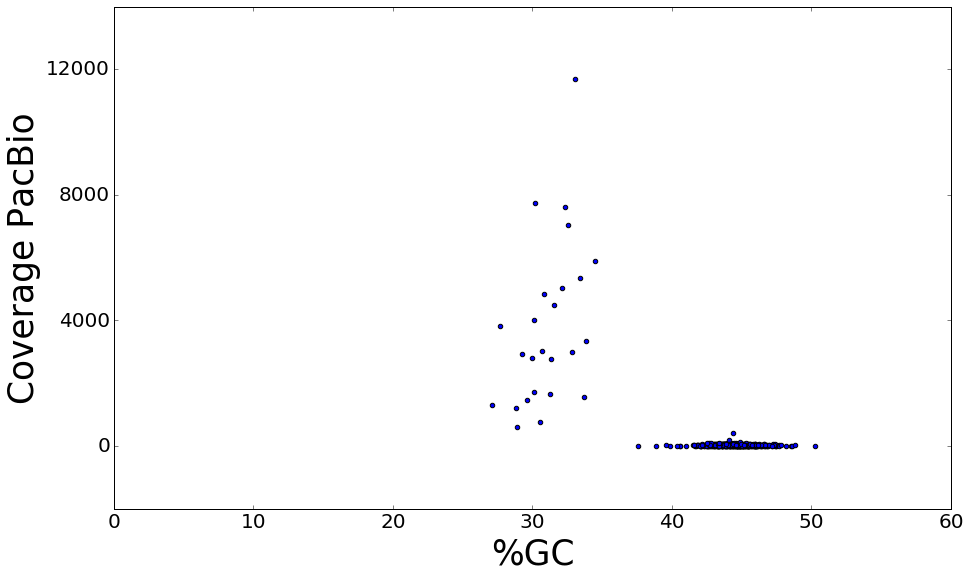

In [65]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'xx-large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'xx-large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Coverage PacBio', **label_config_y)
plt.yticks(range(0,14000,4000))
plt.xlim(0,60)
#plt.savefig(outdir+'/'+)

(0, 60)

/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


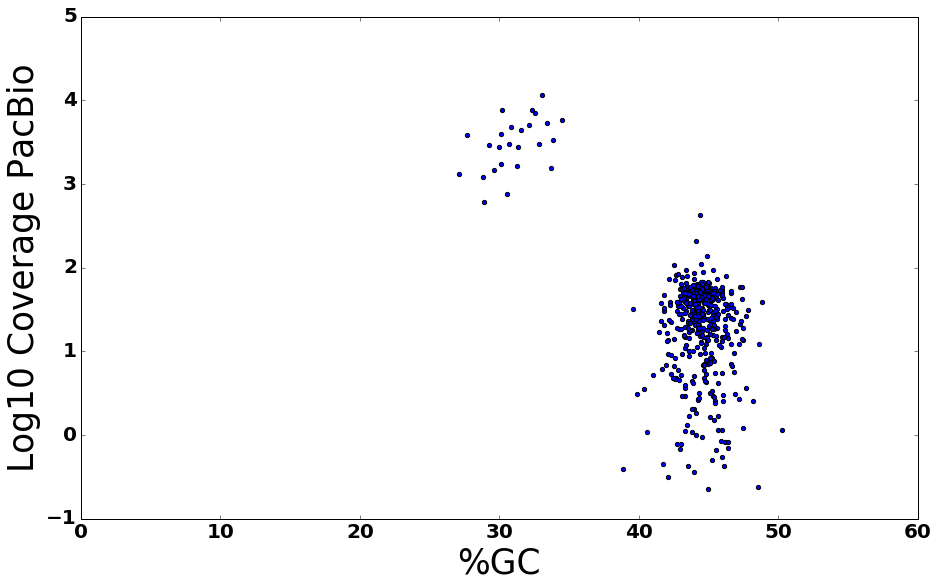

In [66]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']), s=18)
matplotlib.rc('font', **font) #changes font of the plot
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Coverage PacBio', **label_config_y)
plt.ylim(-1,5)
plt.xlim(0,60)

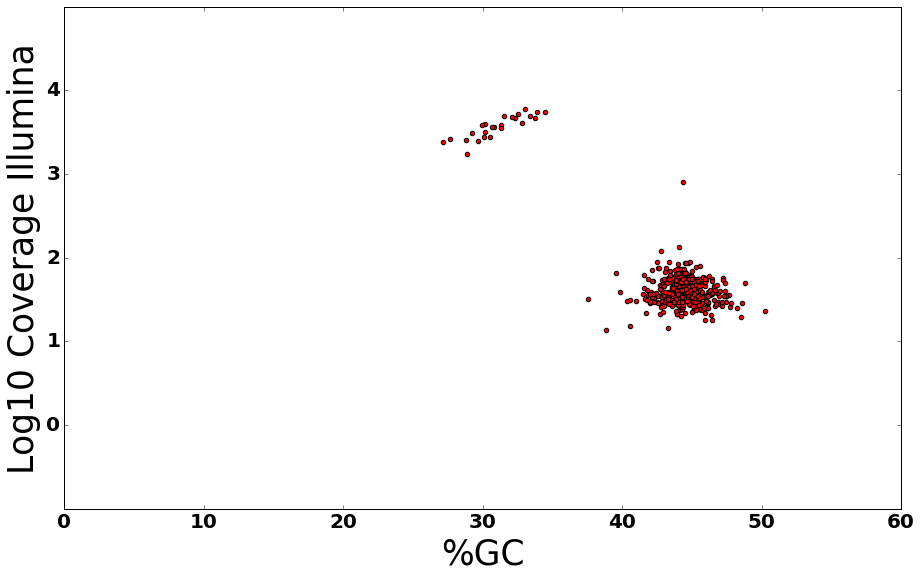

In [67]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina']), c='r')
matplotlib.rc('font', **font) #changes font of the plot
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Coverage Illumina', **label_config_y)

plt.xlim(0,60)
plt.ylim(-1,5)
plt.yticks(range(0,5,1))
plt.savefig(outdir_fig+g_prefix+'log10_Illumina_cov_cgt.png' ,dpi=300)

In [68]:
p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] < 37]

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
563,000151F|quiver,67097,30.174225,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,2,0,409,411,99.51,000151F|quiver,7747.239,3957.160
597,000183F|quiver,45398,30.803119,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,110,110,100.00,000183F|quiver,4849.185,3646.407
606,000190F|quiver,40395,32.573338,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,575,575,100.00,000190F|quiver,7029.506,5271.954
611,000194F|quiver,39140,29.228411,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,136,136,100.00,000194F|quiver,2933.768,3110.121
613,000196F|quiver,37481,28.878632,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,136,136,100.00,000196F|quiver,603.863,1734.159
614,000197F|quiver,37507,32.345962,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,552,552,100.00,000197F|quiver,7620.539,4672.190
615,000198F|quiver,37142,29.949922,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,2,0,337,339,99.41,000198F|quiver,2800.147,3887.970
617,000201F|quiver,35902,33.867194,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,559,559,100.00,000201F|quiver,3354.646,5452.644
624,000209F|quiver,34618,33.731007,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,554,554,100.00,000209F|quiver,1571.341,4605.425
626,000211F|quiver,33668,29.639420,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,83,83,100.00,000211F|quiver,1452.323,2503.752


([<matplotlib.axis.YTick at 0x11cccfc18>,
 <a list of 5 Text yticklabel objects>)

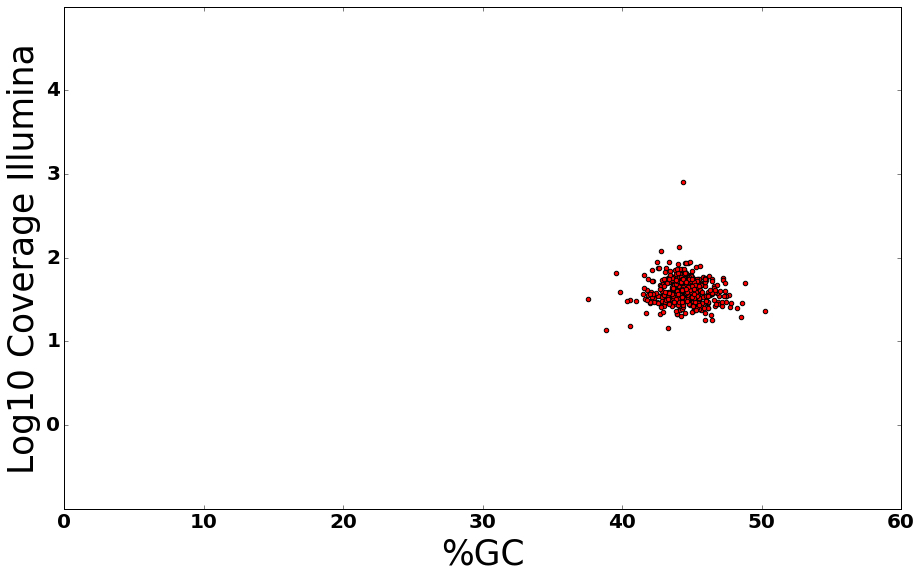

In [69]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] > 37]['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] > 37]['Average Coverage Illumina']), c='r')
matplotlib.rc('font', **font) #changes font of the plot
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Coverage Illumina', **label_config_y)

plt.xlim(0,60)
plt.ylim(-1,5)
plt.yticks(range(0,5,1))

(0, 60)

/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


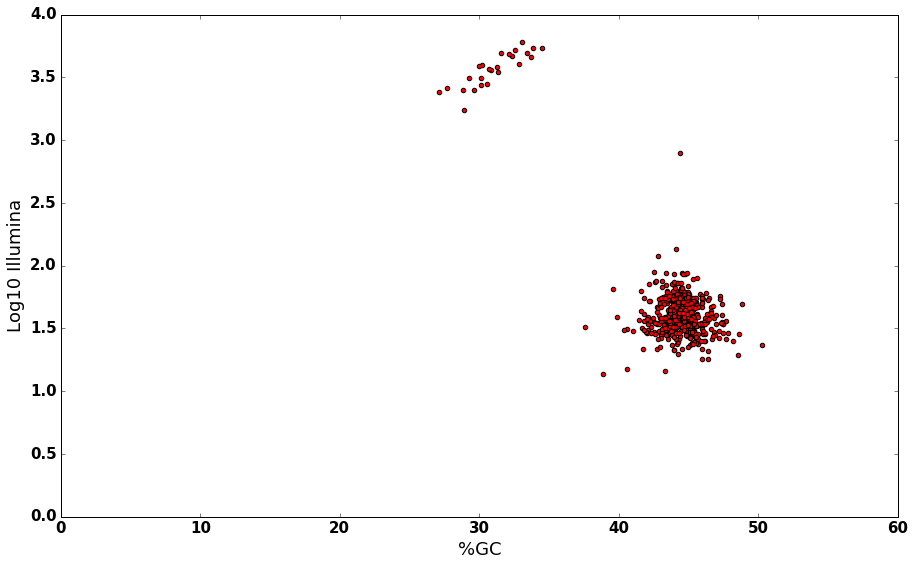

In [70]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina']),  c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Illumina', **label_config_y)
plt.ylim(0,4)
plt.xlim(0,60)

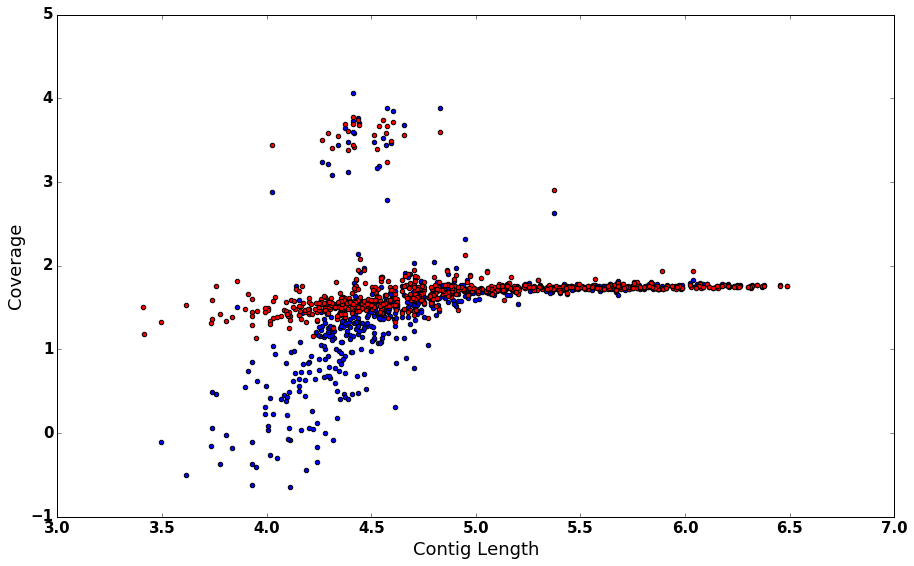

In [71]:
#contig_length vs Coverage
plt.figure(figsize=(15,9))
plt.scatter(y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']), x=np.log10(p_and_a_ctg_blast_cov_df['Length']))
plt.scatter(y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina']), x=np.log10(p_and_a_ctg_blast_cov_df['Length']), c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('Coverage', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,14000)
plt.savefig(outdir_fig+g_prefix+'_log10_cov_cgt.png' ,dpi=300)

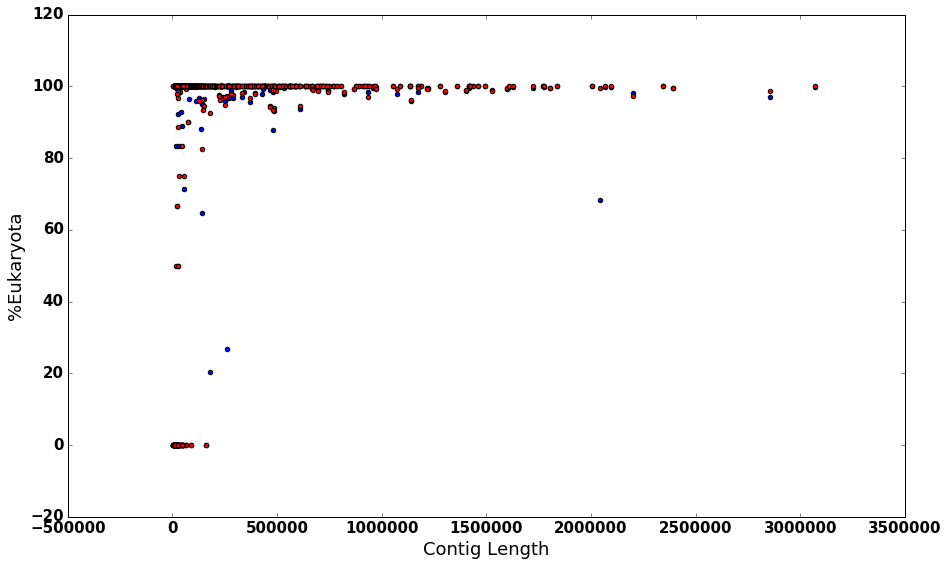

In [72]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Eukaryota'])
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Eukaryota'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

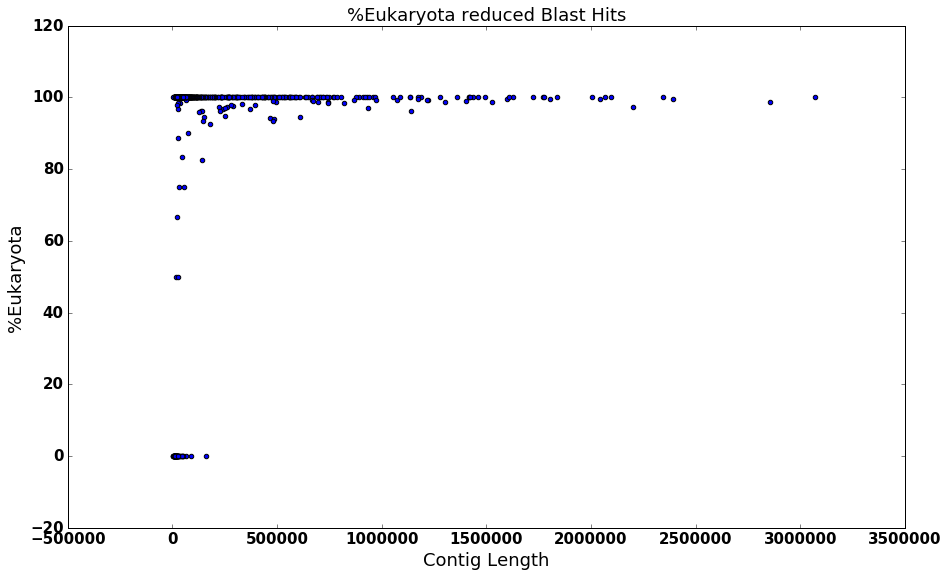

In [73]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Eukaryota'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
plt.title("%Eukaryota reduced Blast Hits")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

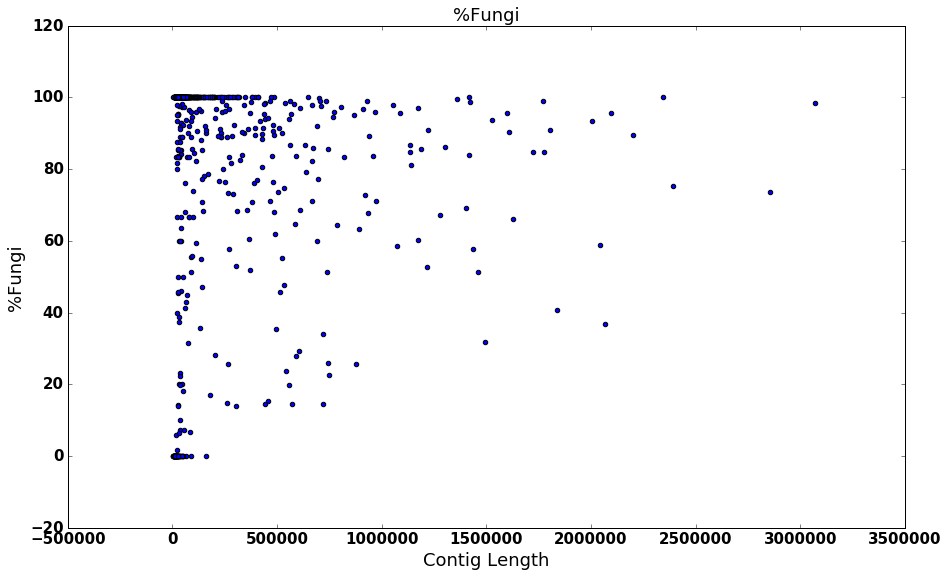

In [74]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Fungi'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
plt.title("%Fungi")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

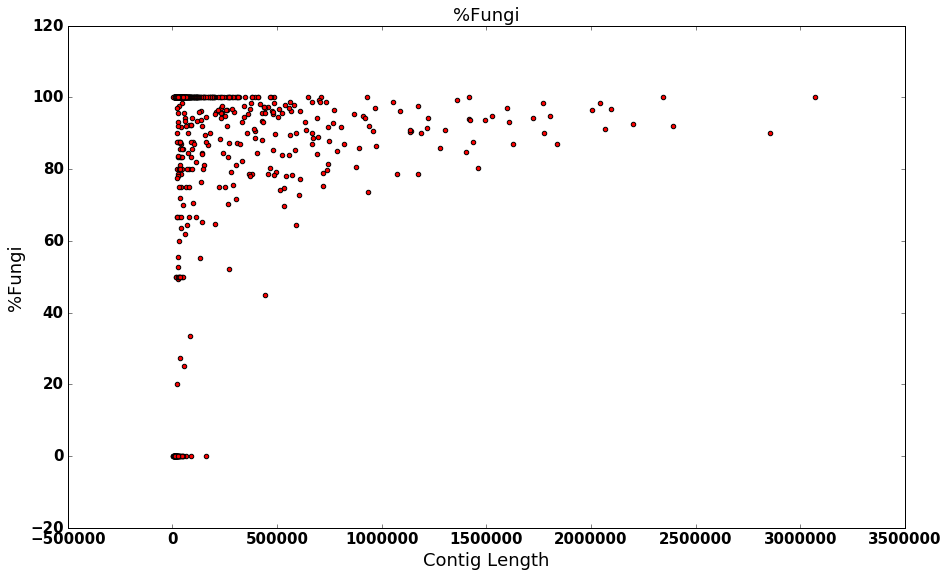

In [75]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Fungi'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
plt.title("%Fungi")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

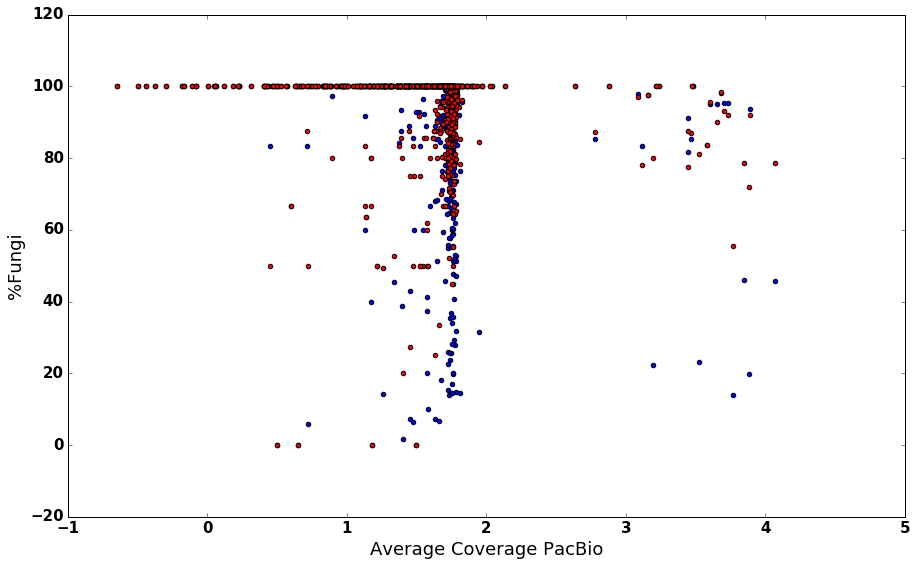

In [76]:
plt.figure(figsize=(15,9))
plt.scatter(x=np.log10(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['Average Coverage PacBio']), y=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%Fungi'])
plt.scatter(x=np.log10(p_and_a_ctg_blast_cov_df_2[p_and_a_ctg_blast_cov_df_2['Total Blast Hits'] >0]['Average Coverage PacBio']), y=p_and_a_ctg_blast_cov_df_2[p_and_a_ctg_blast_cov_df_2['Total Blast Hits'] >0]['%Fungi'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Average Coverage PacBio", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

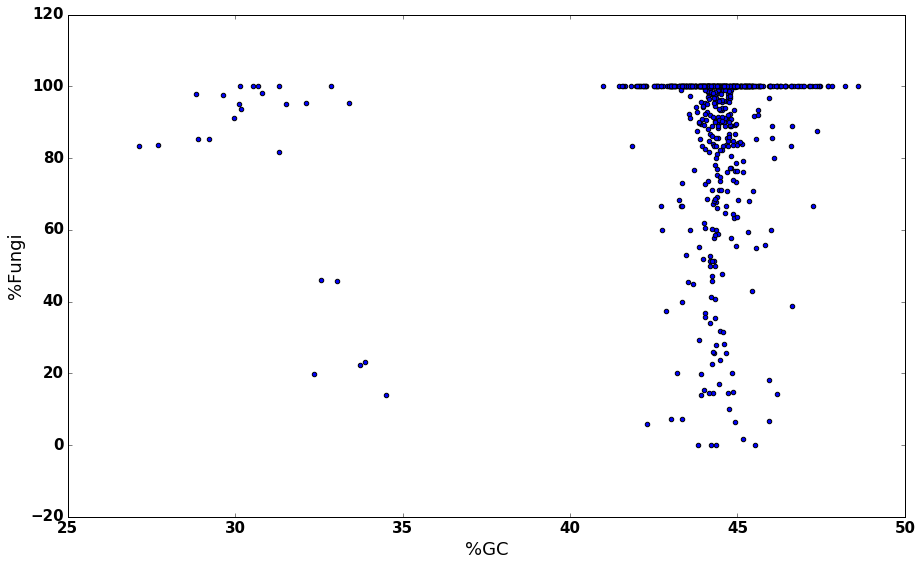

In [77]:
plt.figure(figsize=(15,9))
plt.scatter(x=(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%GC']), y=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%Fungi'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

In [78]:
cov_contig_illumina = coverage_df_generator(cov_path_2, cov_file_name_2, seq_type_2)

In [79]:
cov_contig_illumina.head()

,ID-cov Illumina,start Illumina,stop Illumina,total hits Illumina,Average Coverage Illumina
0,000000F_003|quiver,0,2066231,113196781,54.784
1,000000F_005|quiver,0,12961,328505,25.346
2,000000F_011|quiver,0,10913,462147,42.348
3,000000F_024|quiver,0,37946,1445897,38.104
4,000000F_027|quiver,0,41706,1504023,36.063


In [80]:
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [81]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F_003|quiver,2066231,44.027846,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,1,799,800,99.88,000000F,55.932,54.784
1,000000F_005|quiver,12961,46.169277,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,8,8,100.00,000000F,0.823,25.346
2,000000F_011|quiver,10913,43.626867,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,1,1,100.00,000000F,8.794,42.348
3,000000F_024|quiver,37946,42.984768,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,2,2,100.00,000000F,28.104,38.104
4,000000F_027|quiver,41706,43.370258,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,6,6,100.00,000000F,30.022,36.063


/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


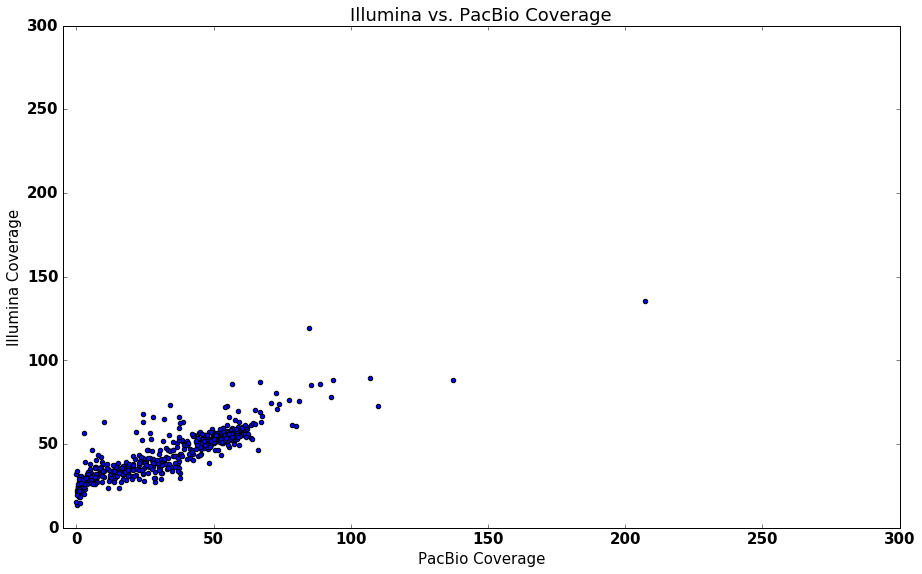

In [82]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'], y=p_and_a_ctg_blast_cov_df['Average Coverage Illumina'])
plt.ylabel("Illumina Coverage")
plt.xlabel("PacBio Coverage")
plt.xlim(-5,300)
plt.ylim(0,300)
plt.title("Illumina vs. PacBio Coverage")

In [83]:
#overall number of contigs
p_and_a_ctg_blast_cov_df["ID"].count()

656

In [84]:
#number of contigs with <200 coverage for both
below_200_cov = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 200) & (p_and_a_ctg_blast_cov_df['Average Coverage Illumina'] < 200)]

In [85]:
below_200_cov["ID"].count()

629

In [86]:
above_200_cov = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] > 200) | (p_and_a_ctg_blast_cov_df['Average Coverage Illumina'] > 200)]

In [87]:
used_header = ["ID", "Length" ,"%GC", "%Fungi","%Eukaryota" ,"Total Blast Hits", "Average Coverage PacBio", "Average Coverage Illumina"]

In [88]:
low_coverage_PacBio = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 10].loc[:, used_header]

In [89]:
p_and_a_ctg_blast_cov_df['Average Coverage PacBio'].median()

46.332

In [90]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/scripts


In [91]:
len(low_coverage_PacBio)

104

In [92]:
np.count_nonzero(low_coverage_PacBio['%Fungi'])

72

In [93]:
low_coverage_PacBio.sort_values(by='Length')

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
118,000010F_021|quiver,2556,37.558685,0.00,0.00,0,0.000,32.373
285,000033F_003|quiver,2587,40.587553,0.00,0.00,0,0.000,15.136
51,000003F_039|quiver,3134,42.724952,0.00,0.00,0,0.776,21.526
431,000068F_004|quiver,4117,42.118047,100.00,100.00,3,0.318,34.058
50,000003F_038|quiver,5434,46.393081,0.00,0.00,0,0.710,20.920
95,000007F_018|quiver,5469,50.265131,0.00,0.00,0,1.156,23.384
131,000012F_005|quiver,5490,39.836066,0.00,0.00,0,3.120,39.118
178,000017F_023|quiver,5717,43.309428,100.00,100.00,2,2.913,56.807
398,000057F_004|quiver,6001,43.559407,100.00,100.00,1,0.425,26.202
352,000046F_004|quiver,6419,44.492912,0.00,0.00,0,0.940,21.714


In [94]:
#get ID list to look at for coverage across those contigs
low_coverage_PacBio["ID"].tolist()

['000000F_005|quiver',
 '000000F_011|quiver',
 '000000F_029|quiver',
 '000000F_036|quiver',
 '000000F_037|quiver',
 '000000F_039|quiver',
 '000000F_049|quiver',
 '000001F_016|quiver',
 '000001F_029|quiver',
 '000001F_033|quiver',
 '000001F_044|quiver',
 '000002F_023|quiver',
 '000003F_005|quiver',
 '000003F_015|quiver',
 '000003F_025|quiver',
 '000003F_026|quiver',
 '000003F_038|quiver',
 '000003F_039|quiver',
 '000004F_007|quiver',
 '000004F_008|quiver',
 '000004F_014|quiver',
 '000004F_016|quiver',
 '000004F_019|quiver',
 '000004F_021|quiver',
 '000004F_025|quiver',
 '000004F_027|quiver',
 '000005F_016|quiver',
 '000006F_016|quiver',
 '000006F_021|quiver',
 '000006F_036|quiver',
 '000007F_001|quiver',
 '000007F_018|quiver',
 '000007F_025|quiver',
 '000007F_031|quiver',
 '000009F_015|quiver',
 '000009F_020|quiver',
 '000010F_008|quiver',
 '000010F_021|quiver',
 '000011F_001|quiver',
 '000011F_013|quiver',
 '000012F_005|quiver',
 '000012F_011|quiver',
 '000012F_025|quiver',
 '000013F_0

In [95]:
low_coverage_PacBio_blast_df = tc_blast_df(blast_xml_path ,blast_xml_file_name, low_coverage_PacBio["ID"].tolist())

In [96]:
print_first_5_blast_hits(low_coverage_PacBio_blast_df)

000079F_001|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19524), mRNA
000079F_001|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19523), mRNA
000084F_002|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_11342), mRNA
000084F_002|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_21384), mRNA
000062F_009|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_03420), mRNA
000062F_009|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15500), mRNA
000062F_009|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_01080), mRNA
000062F_009|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02701), mRNA
000062F_009|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_00343), mRNA
0

In [97]:
below_50_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 50)& (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]

In [98]:
below_50_Fungi_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_50_Fungi["ID"].tolist())

In [99]:
print_first_5_blast_hits(tc_blast_df(blast_xml_path, blast_xml_file_name, below_50_Fungi["ID"].tolist()))

000147F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_03501), mRNA
000147F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_03488), mRNA
000147F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_03502), mRNA
000147F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_18900), mRNA
000147F|quiver 	  Phakopsora pachyrhizi clone JGIAFNA-5B18, complete sequence
000054F|quiver 	  Puccinia striiformis f. sp. tritici clone PST130_10010_2 hypothetical protein gene, complete cds
000054F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19538), mRNA
000054F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_13088), mRNA
000054F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19535), mRNA
000054F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-

In [100]:
below_20_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 20) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]
below_10_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 10) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]

In [101]:
below_10_Fungi_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_10_Fungi["ID"].tolist())

In [102]:
below_10_Fungi

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
42,000003F_005|quiver,14584,42.286067,5.88,100.00,17,5.302,32.573
83,000006F_016|quiver,17036,43.824842,0.00,100.00,2,4.485,30.508
204,000020F_008|quiver,36204,45.539167,0.00,100.00,1,15.192,34.033
212,000020F_023|quiver,14339,44.347584,0.00,100.00,1,3.162,26.038
272,000030F_006|quiver,30392,44.222164,0.00,100.00,2,31.315,37.254
351,000046F_001|quiver,37912,43.345115,7.30,100.00,767,28.567,38.728
403,000058F_005|quiver,82458,45.931262,6.82,100.00,762,45.528,50.616
538,000129F_001|quiver,33147,44.942227,6.45,100.00,62,29.730,38.799
572,000160F|quiver_000017F|quiver,56541,43.004192,7.14,71.43,14,42.614,55.060
655,000248F|quiver,21899,45.152747,1.69,100.00,59,25.354,37.328


In [103]:
below_10_Fungi_blast_df

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000248F|quiver,gi|403162328|ref|XM_003322519.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[10734],[2043],[0.0]
1,000248F|quiver,gi|704519246|ref|XM_010084396.1|,PREDICTED: Pterocles gutturalis clathrin heav...,[12232],[317],[1.81806e-28]
2,000248F|quiver,gi|701420456|ref|XM_009974988.1|,PREDICTED: Tyto alba clathrin heavy chain 1-l...,[12232],[317],[1.81806e-28]
3,000248F|quiver,gi|701420451|ref|XM_009974987.1|,PREDICTED: Tyto alba clathrin heavy chain 1-l...,[12232],[317],[1.81806e-28]
4,000248F|quiver,gi|723552472|ref|XM_010300460.1|,PREDICTED: Balearica regulorum gibbericeps cl...,[12287],[263],[3.04225e-26]
5,000248F|quiver,gi|723552469|ref|XM_010300459.1|,PREDICTED: Balearica regulorum gibbericeps cl...,[12287],[263],[3.04225e-26]
6,000248F|quiver,gi|902877925|ref|XM_013173566.1|,PREDICTED: Anser cygnoides domesticus clathri...,[12232],[318],[1.83097e-23]
7,000248F|quiver,gi|701363193|ref|XM_009987109.1|,PREDICTED: Tauraco erythrolophus clathrin hea...,[12232],[318],[1.83097e-23]
8,000248F|quiver,gi|768380525|ref|XM_011589565.1|,PREDICTED: Aquila chrysaetos canadensis clath...,[12287],[263],[6.58532e-23]
9,000248F|quiver,gi|768380523|ref|XM_011589564.1|,PREDICTED: Aquila chrysaetos canadensis clath...,[12287],[263],[6.58532e-23]


In [104]:
print_all_blast_hits(below_10_Fungi_blast_df)

000248F|quiver 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 clathrin, heavy polypeptide (PGTG_04104), mRNA
E-value 	 [0.0]
Contig Pos Aln 	 [10734]
000248F|quiver 	  PREDICTED: Pterocles gutturalis clathrin heavy chain 1-like (LOC104469759), mRNA
E-value 	 [1.81806e-28]
Contig Pos Aln 	 [12232]
000248F|quiver 	  PREDICTED: Tyto alba clathrin heavy chain 1-like (LOC104367809), transcript variant X2, mRNA
E-value 	 [1.81806e-28]
Contig Pos Aln 	 [12232]
000248F|quiver 	  PREDICTED: Tyto alba clathrin heavy chain 1-like (LOC104367809), transcript variant X1, mRNA
E-value 	 [1.81806e-28]
Contig Pos Aln 	 [12232]
000248F|quiver 	  PREDICTED: Balearica regulorum gibbericeps clathrin heavy chain 1-like (LOC104634043), transcript variant X2, mRNA
E-value 	 [3.04225e-26]
Contig Pos Aln 	 [12287]
000248F|quiver 	  PREDICTED: Balearica regulorum gibbericeps clathrin heavy chain 1-like (LOC104634043), transcript variant X1, mRNA
E-value 	 [3.04225e-26]
Contig Pos Aln 	 [12287]
000248F|quive

In [105]:
below_50_Fungi

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
0,000000F_003|quiver,2066231,44.027846,36.75,99.88,800,55.932,54.784
18,000001F_014|quiver,27150,46.184162,14.20,92.23,528,18.149,28.525
42,000003F_005|quiver,14584,42.286067,5.88,100.00,17,5.302,32.573
43,000003F_013|quiver,263580,44.299264,25.69,100.00,109,56.191,56.975
74,000005F_029|quiver,24094,43.342741,40.00,100.00,5,14.981,34.102
78,000006F_002|quiver,179800,44.441602,16.92,20.34,526,56.802,58.002
83,000006F_016|quiver,17036,43.824842,0.00,100.00,2,4.485,30.508
87,000006F_033|quiver,262777,44.858568,14.92,26.74,516,60.679,55.615
105,000008F|quiver,1839735,44.339919,40.62,100.00,613,58.428,57.536
143,000013F_010|quiver,455884,43.994964,15.25,100.00,754,52.984,54.685


In [106]:
Eu_smaller_70 = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df["%Eukaryota"] < 70) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0)].loc[:,used_header]

In [107]:
Eu_smaller_70

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
78,000006F_002|quiver,179800,44.441602,16.92,20.34,526,56.802,58.002
87,000006F_033|quiver,262777,44.858568,14.92,26.74,516,60.679,55.615
90,000006F|quiver,2041788,44.434339,58.75,68.19,657,57.869,56.395
309,000036F_007|quiver,21176,43.313185,66.67,66.67,3,3.966,31.941
469,000082F_001|quiver,24165,44.175460,50.00,50.00,2,16.590,35.458
513,000107F|quiver_000066F|quiver,141628,44.243370,47.06,64.71,34,60.396,59.379


In [108]:
syn_construct_hits = blast_df[blast_df['sscinames'] ==  'synthetic construct']['sseqid'].tolist()

In [109]:
#maybe check those contigs
blast_df[blast_df['sscinames'] ==  'synthetic construct']['ID']

8396                    000044F|quiver
13488                   000030F|quiver
13489                   000030F|quiver
13490                   000030F|quiver
13491                   000030F|quiver
13492                   000030F|quiver
13493                   000030F|quiver
18532                   000013F|quiver
20942                   000009F|quiver
22683                   000006F|quiver
22684                   000006F|quiver
33362                   000002F|quiver
34218                   000003F|quiver
43302    000093F|quiver_000008F|quiver
65299               000044F_023|quiver
70145               000030F_011|quiver
70146               000030F_011|quiver
70149               000030F_011|quiver
70150               000030F_011|quiver
70151               000030F_011|quiver
70152               000030F_011|quiver
77259               000013F_023|quiver
80157               000006F_002|quiver
80158               000006F_002|quiver
80977               000006F_033|quiver
80978               00000

In [110]:
#look for low %eukaryot hits
Eu_smaller_80_reduced = p_and_a_ctg_blast_cov_df_2[(p_and_a_ctg_blast_cov_df_2['%Eukaryota'] < 80) & (p_and_a_ctg_blast_cov_df_2['%Eukaryota'] > 0)]

In [111]:
Eu_smaller_80_reduced_df = tc_blast_df(blast_xml_path, blast_xml_file_name,Eu_smaller_80_reduced["ID"].tolist())

In [112]:
Eu_smaller_80_reduced_df

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000160F|quiver_000017F|quiver,gi|112434054|gb|DQ833451.1|,Ehrlichia ruminantium strain Sankat NADH-quin...,[46875],[298],[9.95475e-40]
1,000160F|quiver_000017F|quiver,gi|112434050|gb|DQ833449.1|,Ehrlichia ruminantium strain Kumm1 NADH-quino...,[46875],[298],[9.95475e-40]
2,000160F|quiver_000017F|quiver,gi|118566999|gb|CP000488.1|,Candidatus Ruthia magnifica str. Cm (Calyptog...,[46875],[295],[2.15483e-36]
3,000160F|quiver_000017F|quiver,gi|751793169|ref|XM_011207957.1|,PREDICTED: Bactrocera dorsalis NADH-ubiquinon...,[46875],[250],[4.66438e-33]
4,000160F|quiver_000017F|quiver,gi|751793167|ref|XM_011207956.1|,PREDICTED: Bactrocera dorsalis NADH-ubiquinon...,[46875],[250],[4.66438e-33]
5,000160F|quiver_000017F|quiver,gi|820845642|ref|XM_003693006.2|,PREDICTED: Apis florea probable NADH dehydrog...,[46879],[292],[1.30608e-28]
6,000160F|quiver_000017F|quiver,gi|795024708|ref|XM_012005971.1|,PREDICTED: Vollenhovia emeryi NADH-ubiquinone...,[46875],[297],[4.69749e-28]
7,000160F|quiver_000017F|quiver,gi|567373620|gb|CP006745.1|,"Candidatus Endolissoclinum faulkneri L5, comp...",[46875],[297],[1.68952e-27]
8,000160F|quiver_000017F|quiver,gi|572298467|ref|XM_006615322.1|,PREDICTED: Apis dorsata NADH dehydrogenase [u...,[46879],[292],[6.07659e-27]
9,000160F|quiver_000017F|quiver,gi|571541021|ref|XM_006569431.1|,PREDICTED: Apis mellifera NADH dehydrogenase ...,[46879],[292],[6.11973e-22]


In [113]:
print_all_blast_hits(Eu_smaller_80_reduced_df)

000160F|quiver_000017F|quiver 	  Ehrlichia ruminantium strain Sankat NADH-quinone oxidoreductase chain B gene, complete cds
E-value 	 [9.95475e-40]
Contig Pos Aln 	 [46875]
000160F|quiver_000017F|quiver 	  Ehrlichia ruminantium strain Kumm1 NADH-quinone oxidoreductase chain B gene, complete cds >gi
E-value 	 [9.95475e-40]
Contig Pos Aln 	 [46875]
000160F|quiver_000017F|quiver 	  Candidatus Ruthia magnifica str. Cm (Calyptogena magnifica), complete genome
E-value 	 [2.15483e-36]
Contig Pos Aln 	 [46875]
000160F|quiver_000017F|quiver 	  PREDICTED: Bactrocera dorsalis NADH-ubiquinone oxidoreductase 20 kDa subunit (LOC105228231), transcript variant X2, mRNA
E-value 	 [4.66438e-33]
Contig Pos Aln 	 [46875]
000160F|quiver_000017F|quiver 	  PREDICTED: Bactrocera dorsalis NADH-ubiquinone oxidoreductase 20 kDa subunit (LOC105228231), transcript variant X1, mRNA
E-value 	 [4.66438e-33]
Contig Pos Aln 	 [46875]
000160F|quiver_000017F|quiver 	  PREDICTED: Apis florea probable NADH dehydrogenase [u

In [114]:
Eu_smaller_90_reduced = p_and_a_ctg_blast_cov_df_2[(p_and_a_ctg_blast_cov_df_2['%Eukaryota'] < 90) & (p_and_a_ctg_blast_cov_df_2['%Eukaryota'] > 0)]

In [115]:
Eu_smaller_90_reduced 

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Histionidae,Acidithiobacillia,Choanoflagellida,...,%Fungi,environmental samples,Eukaryota,Bacteria,ID-blast,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
18,000001F_014|quiver,27150,46.184162,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,1,2,...,49.30,0,63,8,000001F_014|quiver,71,88.73,000001F,18.149,28.525
309,000036F_007|quiver,21176,43.313185,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,66.67,0,2,1,000036F_007|quiver,3,66.67,000036F,3.966,31.941
370,000049F_010|quiver,15193,44.309880,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,50.00,0,1,1,000049F_010|quiver,2,50.00,000049F,2.812,29.223
469,000082F_001|quiver,24165,44.175460,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,50.00,0,1,1,000082F_001|quiver,2,50.00,000082F,16.590,35.458
486,000090F_001|quiver,30117,41.836836,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,75.00,0,3,1,000090F_001|quiver,4,75.00,000090F,33.262,35.986
513,000107F|quiver_000066F|quiver,141628,44.243370,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,65.22,0,19,4,000107F|quiver_000066F|quiver,23,82.61,000107F,60.396,59.379
516,000110F_003|quiver,47864,46.042955,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,83.33,1,5,0,000110F_003|quiver,6,83.33,000110F,42.909,54.774
572,000160F|quiver_000017F|quiver,56541,43.004192,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,25.00,0,3,1,000160F|quiver_000017F|quiver,4,75.00,000160F,42.614,55.060


In [116]:
High_PacBio_coverage_300 = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] > 300]

In [117]:
High_PacBio_coverage_300_df = tc_blast_df(blast_xml_path, blast_xml_file_name, High_PacBio_coverage_300["ID"].tolist())

In [118]:
print_first_5_blast_hits(High_PacBio_coverage_300_df)

000241F|quiver 	  Phakopsora meibomiae mitochondrion, complete genome
000241F|quiver 	  Phakopsora pachyrhizi mitochondrion, complete genome
000241F|quiver 	  Hemileia vastatrix microsatellite Hva01506 sequence
000241F|quiver 	  Puccinia kuehnii microsatellite Stv_Puk_164 sequence
000241F|quiver 	  Xanthophyllomyces dendrorhous genome assembly Xden1, scaffold Scaffold_32
000234F|quiver 	  Macruropyxis fraxini voucher ZT Myc 56551 ATP synthase subunit 6 (atp6) gene, partial cds; mitochondrial
000234F|quiver 	  Phakopsora meibomiae mitochondrion, complete genome
000234F|quiver 	  Ceratocoma jacksoniae cytochrome c oxidase subunit 3 gene, partial cds; mitochondrial
000234F|quiver 	  Phakopsora pachyrhizi mitochondrion, complete genome
000234F|quiver 	  Melampsora populnea f. sp. laricis isolate 01F1 cytochrome c oxidase subunit 3 (CO3) gene, partial cds; mitochondrial >gi
000238F|quiver 	  Macruropyxis fraxini voucher ZT Myc 56551 ATP synthase subunit 6 (atp6) gene, partial cds; mitochond

In [119]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F_003|quiver,2066231,44.027846,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,1,799,800,99.88,000000F,55.932,54.784
1,000000F_005|quiver,12961,46.169277,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,8,8,100.00,000000F,0.823,25.346
2,000000F_011|quiver,10913,43.626867,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,1,1,100.00,000000F,8.794,42.348
3,000000F_024|quiver,37946,42.984768,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,2,2,100.00,000000F,28.104,38.104
4,000000F_027|quiver,41706,43.370258,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,6,6,100.00,000000F,30.022,36.063


(0, 400)

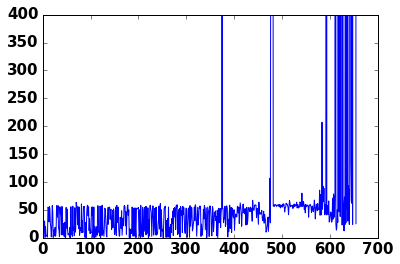

In [120]:
plt.plot(range(0,len(p_and_a_ctg_blast_cov_df)),p_and_a_ctg_blast_cov_df.sort_values(by=[ 'P_contig','ID'])['Average Coverage PacBio'] )
plt.ylim(0,400)

In [121]:
set(High_PacBio_coverage_300["ID"].tolist())

{'000070F_009|quiver',
 '000151F|quiver',
 '000183F|quiver',
 '000190F|quiver',
 '000194F|quiver',
 '000196F|quiver',
 '000197F|quiver',
 '000198F|quiver',
 '000201F|quiver',
 '000209F|quiver',
 '000211F|quiver',
 '000216F|quiver',
 '000226F|quiver',
 '000227F|quiver',
 '000234F_001|quiver',
 '000234F_002|quiver',
 '000234F|quiver',
 '000236F|quiver',
 '000237F|quiver',
 '000238F_001|quiver',
 '000238F_002|quiver',
 '000238F|quiver',
 '000241F_001|quiver',
 '000241F|quiver',
 '000245F|quiver',
 '000247F|quiver'}

In [122]:
mitoch_df = tc_blast_search_df(blast_xml_path, blast_xml_file_name, p_and_a_ctg_df["ID"].tolist(), 'mitoch')

In [123]:
above_200_cov_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, above_200_cov["ID"].tolist())

In [124]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/scripts


In [125]:
#27 congtigs are p, 2 are h, and only hit mitoch and ribosomal RNA
above_200_cov_blast_df.to_csv(blast_xml_path+'/'+ g_prefix+  '_above_200_cov_blast.csv')

In [126]:
below_200_cov["ID"].count()

629

In [127]:
above_200_cov["ID"].count()

27

In [128]:
p_and_a_ctg_blast_cov_df["ID"].count()

656

In [129]:
below_200_cov.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F_003|quiver,2066231,44.027846,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,1,799,800,99.88,000000F,55.932,54.784
1,000000F_005|quiver,12961,46.169277,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,8,8,100.00,000000F,0.823,25.346
2,000000F_011|quiver,10913,43.626867,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,1,1,100.00,000000F,8.794,42.348
3,000000F_024|quiver,37946,42.984768,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,2,2,100.00,000000F,28.104,38.104
4,000000F_027|quiver,41706,43.370258,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,6,6,100.00,000000F,30.022,36.063


# Specific analysis of v91_cns

In [130]:
below_37GC = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] < 37]

In [131]:
below_37GC["ID"].count()

25

In [132]:
set(below_37GC["ID"].tolist()) - set(above_200_cov['ID'].tolist())

set()

In [133]:
set(above_200_cov['ID'].tolist())-set(below_37GC["ID"].tolist())

{'000070F_009|quiver', '000134F|quiver'}

In [134]:
p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['ID'] =='000070F_009|quiver'] #check this out

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
442,000070F_009|quiver,235372,44.400353,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,0,0,0,0,14395,14395,100.0,000070F,430.435,795.713


In [135]:
p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['ID'] =='000134F|quiver'] 

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
544,000134F|quiver,88575,44.107254,v91_cns_gcoords_cur_ph_ctg.fa,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,000134F|quiver,207.137,135.452


(0, 400)

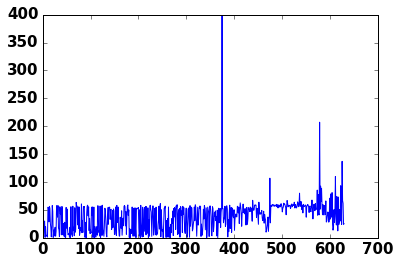

In [136]:
plt.plot(range(0,len(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] > 37])),p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] >37].sort_values(by=[ 'P_contig','ID'])['Average Coverage PacBio'] )
plt.ylim(0,400)

In [137]:
below_37GC_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_37GC["ID"].tolist())

In [138]:
#27 congtigs are p, 2 are h, and only hit mitoch and ribosomal RNA
below_37GC_blast_df.to_csv(blast_xml_path+'/'+ g_prefix+  '_below_37GC_blast.csv')

### These are all smaller 37GC contigs. All appear to hit mitochondria sequences only

In [139]:
below_37GC["ID"].tolist()

['000151F|quiver',
 '000183F|quiver',
 '000190F|quiver',
 '000194F|quiver',
 '000196F|quiver',
 '000197F|quiver',
 '000198F|quiver',
 '000201F|quiver',
 '000209F|quiver',
 '000211F|quiver',
 '000216F|quiver',
 '000226F|quiver',
 '000227F|quiver',
 '000234F_001|quiver',
 '000234F_002|quiver',
 '000234F|quiver',
 '000236F|quiver',
 '000237F|quiver',
 '000238F_001|quiver',
 '000238F_002|quiver',
 '000238F|quiver',
 '000241F_001|quiver',
 '000241F|quiver',
 '000245F|quiver',
 '000247F|quiver']

In [140]:
below_37GC.groupby('P_contig').count()

,ID,Length,%GC,Assembly,A_contig,Verrucomicrobia,Katablepharidaceae,Acidithiobacillia,Choanoflagellida,uncultured eukaryote,...,synthetic construct,Archaea,Bacteria,environmental samples,Eukaryota,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
P_contig,,,,,,,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20


In [141]:
below_37GC['Length'].sum()

763978

In [142]:
below_37GC['Length'].min()

10628

In [143]:
below_37GC['Length'].max()

67097

25 contigs; 20 primary and 5 h contigs; 763978 Mb, 

### These are all contigs with a low hit rate of Eukaryotic blast hits

In [144]:
Eu_smaller_90_reduced

,ID,Length,%GC,Assembly,P_contig,A_contig,Verrucomicrobia,Histionidae,Acidithiobacillia,Choanoflagellida,...,%Fungi,environmental samples,Eukaryota,Bacteria,ID-blast,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
18,000001F_014|quiver,27150,46.184162,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,1,2,...,49.30,0,63,8,000001F_014|quiver,71,88.73,000001F,18.149,28.525
309,000036F_007|quiver,21176,43.313185,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,66.67,0,2,1,000036F_007|quiver,3,66.67,000036F,3.966,31.941
370,000049F_010|quiver,15193,44.309880,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,50.00,0,1,1,000049F_010|quiver,2,50.00,000049F,2.812,29.223
469,000082F_001|quiver,24165,44.175460,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,50.00,0,1,1,000082F_001|quiver,2,50.00,000082F,16.590,35.458
486,000090F_001|quiver,30117,41.836836,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,75.00,0,3,1,000090F_001|quiver,4,75.00,000090F,33.262,35.986
513,000107F|quiver_000066F|quiver,141628,44.243370,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,65.22,0,19,4,000107F|quiver_000066F|quiver,23,82.61,000107F,60.396,59.379
516,000110F_003|quiver,47864,46.042955,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,83.33,1,5,0,000110F_003|quiver,6,83.33,000110F,42.909,54.774
572,000160F|quiver_000017F|quiver,56541,43.004192,v91_cns_gcoords_cur_ph_ctg.fa,0,1,0,0,0,0,...,25.00,0,3,1,000160F|quiver_000017F|quiver,4,75.00,000160F,42.614,55.060


In [145]:
Eu_smaller_90_reduced_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, Eu_smaller_90_reduced["ID"].tolist())

In [146]:
Eu_smaller_90_reduced_blast_df.to_csv(outdir_sum+'/'+ g_prefix+  '_below_90per_eukaryotic.csv')

In [ ]:
#nothing to obvious really

## These are all contigs with a synthetic construct blast hit

In [154]:
syn_hit_df  = blast_df[blast_df['sscinames'] ==  'synthetic construct']

In [150]:
syn_construct_hits

['gi|157169865|gb|BC152885.1|',
 'gi|649122047|gb|KJ897822.1|',
 'gi|649104414|gb|KJ892489.1|',
 'gi|313882499|gb|HQ257982.1|',
 'gi|312153245|gb|HQ448657.1|',
 'gi|307685866|dbj|AB590709.1|',
 'gi|168149437|emb|CU677611.1|',
 'gi|84312788|gb|DQ332525.1|',
 'gi|220948441|gb|FJ632505.1|',
 'gi|220956709|gb|FJ636639.1|',
 'gi|220947263|gb|FJ631916.1|',
 'gi|113060056|gb|DQ888227.1|',
 'gi|84312537|gb|DQ332274.1|',
 'gi|649148621|gb|KJ904413.1|',
 'gi|157169865|gb|BC152885.1|',
 'gi|649122047|gb|KJ897822.1|',
 'gi|649104414|gb|KJ892489.1|',
 'gi|313882499|gb|HQ257982.1|',
 'gi|312153245|gb|HQ448657.1|',
 'gi|307685866|dbj|AB590709.1|',
 'gi|168149437|emb|CU677611.1|',
 'gi|84312788|gb|DQ332525.1|',
 'gi|220956709|gb|FJ636639.1|',
 'gi|220947263|gb|FJ631916.1|',
 'gi|220956709|gb|FJ636639.1|',
 'gi|220947263|gb|FJ631916.1|',
 'gi|649119339|gb|KJ897012.1|',
 'gi|157929199|gb|EU176434.1|',
 'gi|123999832|gb|DQ896426.2|',
 'gi|61372080|gb|AY891855.1|',
 'gi|60655190|gb|AY889368.1|',
 'gi|2618

In [155]:
syn_hit_df.to_csv(outdir_sum+'/'+ g_prefix+  '_synthetic_hits.csv')

In [147]:
above_37GC = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['%GC'] >= 37]